In [1]:
from tqdm.notebook import tqdm
import xml.etree.ElementTree as et
import csv

import numpy as np
np.seterr(all="ignore")

import pandas as pd
from scipy.io import loadmat
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from ndspflow.workflows import WorkFlow

from timescales.fit import PSD
from timescales.autoreg import compute_ar_spectrum
from timescales.utils import create_windows
from timescales.plts import set_default_rc

set_default_rc()

## Minimal Preprocessing Functions

These functions are used to read signals for LFP and spiking data into memory. They are also used to read metadata, channel information, and behavioral annotations. Once this is complete, we pass the np.arrays over to ndspflow's workflow manager to compute and fit power spectral density (PSD).

In [2]:
# Root directory to crncs:fcx-1 data
dirpath = '/Users/ryanhammonds/Desktop/fcx-1'

def read_xml(file):
    """Extracts metadata from .xml files."""
    
    tree = et.parse(file)
    root = tree.getroot()
    
    meta = _read_xml(root)
    
    return meta
    
    
def _read_xml(root, info={}):

    for child in root:
        
        # Recurse
        parents = ['acquisitionSystem', 'fieldPotentials']
        if child.tag in parents:
            _read_xml(child, info)
            
        # Extract
        if child.tag == 'nBits':
            info['n_bits'] = int(child.text)
        elif child.tag == 'nChannels':
            info['n_channels'] = int(child.text)
        elif child.tag == 'lfpSamplingRate':
            info['fs_lfp'] = float(child.text)
            
    return info


def read_channels(f):
    """Read channel labels from csv."""
    
    with open(f) as csvfile:

        reader = csv.reader(csvfile, delimiter=' ', quotechar='|')

        channel_map = {}

        for row in reader:

            ch, loc = row[0].split(',')
            ch = int(ch)
            loc = None if loc == '' else loc
            channel_map[ch] = loc
    
    return channel_map


def read_spikes(base, fs, dirpath=dirpath):
    """Read spikes as sum spikes across E/I sub-units"""
    
    subtype_dict = loadmat(f'{dirpath}/{base}/{base}_SSubtypes.mat')
    subtype_e = subtype_dict['Se_CellFormat'][0]
    subtype_i = subtype_dict['Si_CellFormat'][0]

    n_seconds = np.ceil(max([*[np.max(i) for i in subtype_i], 
                             *[np.max(i) for i in subtype_e]]))

    spikes = np.zeros((2, int(n_seconds * fs)))

    for sind, subtype in enumerate([subtype_e, subtype_i]):
        for s in subtype:
            spikes[sind, (s[:, 0] * fs).astype(int)] = 1
            
    spikes_e = spikes[0]
    spikes_i = spikes[1]
    
    return spikes_e, spikes_i


def read_lfp(base, dirpath=dirpath):
    """Read LFP for mPFC electrodes."""
    
    # Metadata / recording parameters
    f = f'{dirpath}/{base}/{base}.xml'
    meta = read_xml(f)
    fs = meta['fs_lfp']
    n_channels = meta['n_channels']

    # Channel map
    f = f'{dirpath}/{base}/{base}_ChannelAnatomy.csv'
    cm = read_channels(f)

    # Signal indices for mPFC
    inds = [k for k, v in cm.items() if v == 'mPFC']

    # Read LFP
    f = f'{dirpath}/{base}/{base}.eeg'

    with open(f, mode='rb') as file:
        content = file.read()

    sigs = np.frombuffer(content, dtype=np.int16)
    sigs = sigs[:int((len(sigs) // n_channels)*n_channels)]
    sigs = sigs.reshape(-1, n_channels).T

    # Limit to mPFC
    sigs = sigs[inds]
    
    return sigs, fs


def read_annotations(base, fs, win_len, win_spacing, dirpath=dirpath):
    """Read sample indices corresponding to wake and nrem."""
    
    # Windows
    win_len = int(win_len*fs)
    win_spacing = int(win_spacing*fs)
    
    # Extract behavioral data
    beh_file = f'{dirpath}/{base}/{base}_WSRestrictedIntervals.mat'
    beh = loadmat(beh_file)

    nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
    wake = beh['WakeTimePairFormat'].astype(int) *  fs

    # Window by trial type
    wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
    nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

    start_end_wake = np.vstack((wake_starts, wake_ends)).T.astype(int)
    start_end_nrem = np.vstack((nrem_starts, nrem_ends)).T.astype(int)
    
    return start_end_wake, start_end_nrem

In [3]:
# Settings
ar_order = 5
f_range_lfp = (.01, 20)
f_range_spikes = (.01, 20)

# Window length/spacing, in seconds
win_len = 5
win_spacing = 5

# Spikes
fs_spikes = 20000
bin_size = 100

# Specparam
fooof_init = {
    'aperiodic_mode': 'knee_constant',
    'max_n_peaks': 4,
    'peak_threshold': 2.5
}

# Function for binnning spikes
def bin_spikes(spikes, bin_size):
    
    from neurodsp.utils.norm import normalize_sig

    spikes_bin = normalize_sig(
        spikes.reshape(-1, bin_size).sum(axis=1), 0, 1)
    
    return spikes_bin

def flatten_results(results, std=2., units='ms'):
    
    taus = []
    for res in results:
    
        inds = np.where(
            (res <= (res.mean() + (std * res.std()))) &
            (res >= (res.mean() - (std * res.std())))
        )[0]
        
        res = res[inds].flatten()
        
        if units == 'ms':
            res *= 1000
            
        taus.append(res)
        
    return taus

## Raw Data $\rightarrow$ Model Fits

Below, annotations for wake and non-REM are used to split the signal (both LFP and spikes) into 5 second windows. The workflows are defined for:

1. LFP : Wake
2. LFP : Non-REM
3. Spikes : Excitatory : Wake
4. Spikes : Inhibitory : Wake
5. Spikes : Excitatory : Non-REM
6. Spikes : Excitatory : Wake

Each workflow involves computing and fitting an autoregressive PSD. The workflow for spikes additionally includes binning spikes.

In [4]:
bases = [
    '20140526_277um',
    '20140527_421um',
    '20140528_565um',
    #'Dino_061814_mPFC',  -> excessive number of failed fits
    #'Dino_061914_mPFC'   -> shape mismatch
]

lfp, fs_lfp = read_lfp(bases[0])

In [5]:
# Files for 4 rats that have the same:
#   1. Electrode Location (mPFC)
#   2. Wake activity (homecage)
bases = [
    '20140526_277um',
    '20140527_421um',
    '20140528_565um',
    #'Dino_061814_mPFC',  -> excessive number of failed fits
    #'Dino_061914_mPFC'   -> shape mismatch
]

# Track results
results_lfp_wake = []
results_lfp_nrem = []

results_spikes_e_wake = []
results_spikes_e_nrem = []

results_spikes_i_wake = []
results_spikes_i_nrem = []

# Iterate over each animal
for base in bases:
    
    print(f'Running: {base}')
    
    # LFP: read
    lfp, fs_lfp = read_lfp(base)
    
    # LFP: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_lfp, win_len, win_spacing)

    # LFP: split into wake and nrem, shaped as: (n_channels, n_epochs, n_samples)
    lfp_wake = np.array([lfp[:, s:e] for s, e in start_end_wake])
    lfp_wake = np.swapaxes(lfp_wake, 0, 1)

    lfp_nrem = np.array([lfp[:, s:e] for s, e in start_end_nrem])
    lfp_nrem = np.swapaxes(lfp_nrem, 0, 1)

    # Spikes: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_spikes, win_len, win_spacing)

    # Spikes: read
    spikes_e, spikes_i = read_spikes(base, fs_spikes)
    
    # Spikes: annotations
    #   Need to recompute annotations due to differences
    #   in lfp and spike sampling rate.
    spikes_i_wake = np.array([spikes_i[s:e] for s, e in start_end_wake])
    spikes_e_wake = np.array([spikes_e[s:e] for s, e in start_end_wake])

    spikes_i_nrem = np.array([spikes_i[s:e] for s, e in start_end_nrem])
    spikes_e_nrem = np.array([spikes_e[s:e] for s, e in start_end_nrem])

    # Prevent OOM
    del lfp, spikes_e, spikes_i
    
    # Define and run workflows
    # LFP: Wake
    wf_lfp_wake = WorkFlow(y_array=lfp_wake)
    wf_lfp_wake.transform(compute_ar_spectrum, fs_lfp, 10, f_range=f_range_lfp)
    wf_lfp_wake.fit(PSD(), method='huber')
    wf_lfp_wake.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # LFP: NREM
    wf_lfp_nrem = WorkFlow(y_array=lfp_nrem)
    wf_lfp_nrem.transform(compute_ar_spectrum, fs_lfp, 10, f_range=f_range_lfp)
    wf_lfp_nrem.fit(PSD(), method='huber')
    wf_lfp_nrem.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Inhibitory : Wake
    wf_spikes_i_wake = WorkFlow(y_array=spikes_i_wake)

    wf_spikes_i_wake.transform(bin_spikes, bin_size)
    wf_spikes_i_wake.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)
    wf_spikes_i_wake.fit(PSD(), method='huber')
    wf_spikes_i_wake.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Excitatory : Wake
    wf_spikes_e_wake = WorkFlow(y_array=spikes_e_wake)
    wf_spikes_e_wake.transform(bin_spikes, bin_size)
    wf_spikes_e_wake.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)
    wf_spikes_e_wake.fit(PSD(), method='huber')
    wf_spikes_e_wake.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Inhibitory : NREM
    wf_spikes_i_nrem = WorkFlow(y_array=spikes_i_nrem)
    wf_spikes_i_nrem.transform(bin_spikes, bin_size)
    wf_spikes_i_nrem.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)
    wf_spikes_i_nrem.fit(PSD(), method='huber')
    wf_spikes_i_nrem.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Excitatory : NREM
    wf_spikes_e_nrem = WorkFlow(y_array=spikes_e_nrem)
    wf_spikes_e_nrem.transform(bin_spikes, bin_size)
    wf_spikes_e_nrem.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)
    wf_spikes_e_nrem.fit(PSD(), method='huber')
    wf_spikes_e_nrem.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)
    
    # Store results
    results_lfp_wake.append(wf_lfp_wake.results)
    results_lfp_nrem.append(wf_lfp_nrem.results)
    
    results_spikes_e_wake.append(wf_spikes_e_wake.results)
    results_spikes_e_nrem.append(wf_spikes_e_nrem.results)

    results_spikes_i_wake.append(wf_spikes_i_wake.results)
    results_spikes_i_nrem.append(wf_spikes_i_nrem.results)
    
    del lfp_wake, lfp_nrem, spikes_e_nrem, spikes_i_nrem, spikes_e_wake, spikes_i_wake

Running: 20140526_277um


Running Workflow:   0%|          | 0/13664 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/17152 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/427 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/427 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/536 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/536 [00:00<?, ?it/s]

Running: 20140527_421um


Running Workflow:   0%|          | 0/10720 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/12096 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/335 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/335 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/378 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/378 [00:00<?, ?it/s]

Running: 20140528_565um


Running Workflow:   0%|          | 0/5024 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/17280 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/157 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/157 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/540 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/540 [00:00<?, ?it/s]

In [6]:
# Unpack results
taus_lfp_wake = [i[:, :, 0].flatten().astype(float) for i in results_lfp_wake]
taus_lfp_nrem = [i[:, :, 0].flatten().astype(float) for i in results_lfp_nrem]

taus_e_wake = [i[:, 0] for i in results_spikes_e_wake]
taus_i_wake = [i[:, 0] for i in results_spikes_i_wake]

taus_e_nrem = [i[:, 0] for i in results_spikes_e_nrem]
taus_i_nrem = [i[:, 0] for i in results_spikes_i_nrem]

# Remove outliers
std=2

taus_lfp_wake = flatten_results(taus_lfp_wake, std)
taus_lfp_nrem = flatten_results(taus_lfp_nrem, std)

taus_e_wake = flatten_results(taus_e_wake, std)
taus_e_nrem = flatten_results(taus_e_nrem, std)

taus_i_wake = flatten_results(taus_i_wake, std)
taus_i_nrem = flatten_results(taus_i_nrem, std)

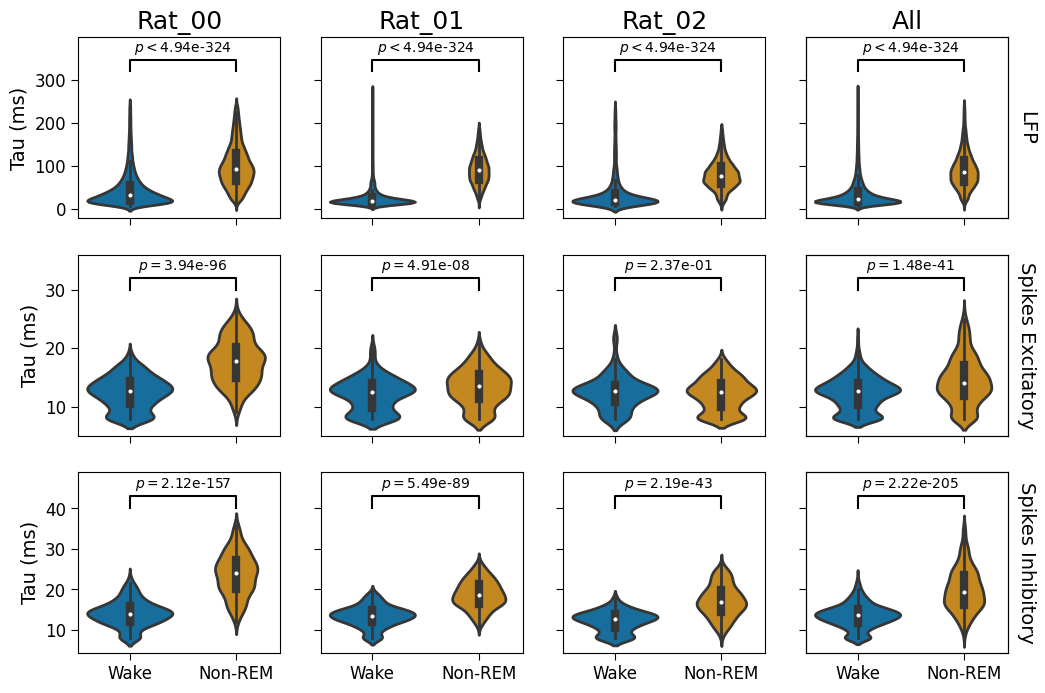

In [7]:
def plot_significance(taus_a, taus_b, ax, y=None, concat=False):
    
    if concat:
        taus_a = np.concatenate(taus_a)
        taus_b = np.concatenate(taus_b)
        
    x1, x2 = 0, 1
    
    if y is None:
        y = max([taus_a.max(), taus_b.max()])
        y += y//8
    
    h, col = y//12, 'k'
    
    pval  = stats.ttest_ind(taus_a.astype(float), taus_b.astype(float)).pvalue
    
    # Round zero smallest possible float
    rounded = False
    if pval == 0:
        rounded = True
        pval = np.nextafter(0, 1)
        
    pval = '{:.2e}'.format(pval)
    
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    if rounded:
        ax.text((x1+x2)*.5, y+h*1.25, fr"$p < ${pval}", ha='center', va='bottom', color=col, size=10)
    else:
        ax.text((x1+x2)*.5, y+h*1.25, fr"$p = ${pval}", ha='center', va='bottom', color=col, size=10)
        
    ax.set_ylim(ax.get_ylim()[0], y+3*h)
    
    
# Plot each animal separately
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8), sharey='row', sharex=True)

for i in range(3):
    sns.violinplot([taus_lfp_wake[i], taus_lfp_nrem[i]], showfliers=False, ax=axes[0][i])
    sns.violinplot([taus_e_wake[i], taus_e_nrem[i]], showfliers=False, ax=axes[1][i])
    sns.violinplot([taus_i_wake[i], taus_i_nrem[i]], showfliers=False, ax=axes[2][i])
    
    plot_significance(taus_lfp_wake[i], taus_lfp_nrem[i], ax=axes[0][i], y=320)
    plot_significance(taus_e_wake[i], taus_e_nrem[i], ax=axes[1][i], y=30)
    plot_significance(taus_i_wake[i], taus_i_nrem[i], ax=axes[2][i], y=40)

# Plot combined across all rats
sns.violinplot([np.concatenate(taus_lfp_wake), np.concatenate(taus_lfp_nrem)],
                showfliers=False, ax=axes[0][3])

sns.violinplot([np.concatenate(taus_e_wake), np.concatenate(taus_e_nrem)],
                showfliers=False, ax=axes[1][3])

sns.violinplot([np.concatenate(taus_i_wake), np.concatenate(taus_i_nrem)],
                showfliers=False, ax=axes[2][3])

_labels = [f'Rat_0{i}' for i in range(3)]
for i, label in enumerate(_labels):
    axes[0][i].set_title(label, size=18)
    
axes[2, 0].set_xticklabels(['Wake', 'Non-REM'])

for ax in axes:
    ax[0].set_ylabel('Tau (ms)', size=14)
    
labels = ['LFP', 'Spikes Excitatory', 'Spikes Inhibitory']

for i in range(3):
    ax = axes[i][3].twinx()
    ax.set_yticks([])
    ax.set_ylabel(labels[i], rotation=-90, size=14,labelpad=15)
    

axes[0, 3].set_title('All', size=18)

plot_significance(taus_lfp_wake, taus_lfp_nrem, ax=axes[0][3], concat=True, y=320)
plot_significance(taus_e_wake, taus_e_nrem, ax=axes[1][3], concat=True, y=30)
plot_significance(taus_i_wake, taus_i_nrem, ax=axes[2][3], concat=True, y=40)

plt.savefig('rat_wake_vs_nrem.pdf', facecolor='white', dpi=300)

In [8]:
# Save to compare to human iEEG in the next notebook
np.save('rat_taus_lfp_wake.npy', np.concatenate(taus_lfp_wake))
np.save('rat_taus_lfp_nrem.npy', np.concatenate(taus_lfp_nrem))

## Dynamic Timecales

This reruns the above, but with a smaller window spacing to track the dynamics of the timescale on a sliding window basis.

In [9]:
# Window length/spacing, in seconds
win_len = 5
win_spacing = 1

# Track results
results_lfp_wake_dynamic = []
results_lfp_nrem_dynamic = []

results_spikes_e_wake_dynamic = []
results_spikes_e_nrem_dynamic = []

results_spikes_i_wake_dynamic = []
results_spikes_i_nrem_dynamic = []

# Iterate over each animal
for base in bases:
    
    print(f'Running: {base}')
    
    # LFP: read
    lfp, fs_lfp = read_lfp(base)
    
    # LFP: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_lfp, win_len, win_spacing)

    # LFP: split into wake and nrem, shaped as: (n_channels, n_epochs, n_samples)
    lfp_wake = np.array([lfp[:, s:e] for s, e in start_end_wake])
    lfp_wake = np.swapaxes(lfp_wake, 0, 1)

    lfp_nrem = np.array([lfp[:, s:e] for s, e in start_end_nrem])
    lfp_nrem = np.swapaxes(lfp_nrem, 0, 1)

    # Spikes: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_spikes, win_len, win_spacing)

    # Spikes: read
    spikes_e, spikes_i = read_spikes(base, fs_spikes)
    
    # Spikes: annotations
    #   Need to recompute annotations due to differences
    #   in lfp and spike sampling rate.
    spikes_i_wake = np.array([spikes_i[s:e] for s, e in start_end_wake])
    spikes_e_wake = np.array([spikes_e[s:e] for s, e in start_end_wake])

    spikes_i_nrem = np.array([spikes_i[s:e] for s, e in start_end_nrem])
    spikes_e_nrem = np.array([spikes_e[s:e] for s, e in start_end_nrem])

    # Prevent OOM
    del lfp, spikes_e, spikes_i
    
    # Define and run workflows
    # LFP: Wake
    wf_lfp_wake = WorkFlow(y_array=lfp_wake)
    wf_lfp_wake.transform(compute_ar_spectrum, fs_lfp, 10, f_range=f_range_lfp)
    # wf_lfp_wake.fit(PSD(), method='fooof', fooof_init=fooof_init, n_jobs=1)
    wf_lfp_wake.fit(PSD(), method='huber')
    wf_lfp_wake.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # LFP: NREM
    wf_lfp_nrem = WorkFlow(y_array=lfp_nrem)
    wf_lfp_nrem.transform(compute_ar_spectrum, fs_lfp, 10, f_range=f_range_lfp)
    # wf_lfp_nrem.fit(PSD(), method='fooof', fooof_init=fooof_init, n_jobs=1)
    wf_lfp_nrem.fit(PSD(), method='huber')
    wf_lfp_nrem.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Inhibitory : Wake
    wf_spikes_i_wake = WorkFlow(y_array=spikes_i_wake)

    wf_spikes_i_wake.transform(bin_spikes, bin_size, mode='notebook')
    wf_spikes_i_wake.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)

    # wf_spikes_i_wake.fit(PSD(), method='fooof', fooof_init=fooof_init)
    wf_spikes_i_wake.fit(PSD(), method='huber')
    wf_spikes_i_wake.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Excitatory : Wake
    wf_spikes_e_wake = WorkFlow(y_array=spikes_e_wake)

    wf_spikes_e_wake.transform(bin_spikes, bin_size, mode='notebook')
    wf_spikes_e_wake.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)

    # wf_spikes_e_wake.fit(PSD(), method='fooof', fooof_init=fooof_init)
    wf_spikes_e_wake.fit(PSD(), method='huber')
    wf_spikes_e_wake.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Inhibitory : NREM
    wf_spikes_i_nrem = WorkFlow(y_array=spikes_i_nrem)

    wf_spikes_i_nrem.transform(bin_spikes, bin_size, mode='notebook')
    wf_spikes_i_nrem.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)

    # wf_spikes_i_nrem.fit(PSD(), method='fooof', fooof_init=fooof_init)
    wf_spikes_i_nrem.fit(PSD(), method='huber')
    wf_spikes_i_nrem.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)

    # Spikes : Excitatory : NREM
    wf_spikes_e_nrem = WorkFlow(y_array=spikes_e_nrem)

    wf_spikes_e_nrem.transform(bin_spikes, bin_size, mode='notebook')
    wf_spikes_e_nrem.transform(compute_ar_spectrum, fs_spikes/bin_size, ar_order,
                               f_range=f_range_spikes)

    # wf_spikes_e_nrem.fit(PSD(), method='fooof', fooof_init=fooof_init)
    wf_spikes_e_nrem.fit(PSD(), method='huber')
    wf_spikes_e_nrem.run(axis=-1, attrs=['tau', 'rsq'], progress=tqdm)
    
    # Store results
    results_lfp_wake_dynamic.append(wf_lfp_wake.results)
    results_lfp_nrem_dynamic.append(wf_lfp_nrem.results)
    
    results_spikes_e_wake_dynamic.append(wf_spikes_e_wake.results)
    results_spikes_e_nrem_dynamic.append(wf_spikes_e_nrem.results)

    results_spikes_i_wake_dynamic.append(wf_spikes_i_wake.results)
    results_spikes_i_nrem_dynamic.append(wf_spikes_i_nrem.results)
    
    del lfp_wake, lfp_nrem, spikes_e_nrem, spikes_i_nrem, spikes_e_wake, spikes_i_wake

Running: 20140526_277um


Running Workflow:   0%|          | 0/68320 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/85632 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/2135 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/2135 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/2676 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/2676 [00:00<?, ?it/s]

Running: 20140527_421um


Running Workflow:   0%|          | 0/53536 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/60384 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/1673 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/1673 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/1887 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/1887 [00:00<?, ?it/s]

Running: 20140528_565um


Running Workflow:   0%|          | 0/25152 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/86432 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/786 [00:00<?, ?it/s]

/Users/ryanhammonds/projects/timescale-methods/.env/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ryanhammonds/projects/timescale-methods/.env/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Running Workflow:   0%|          | 0/786 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/2701 [00:00<?, ?it/s]

Running Workflow:   0%|          | 0/2701 [00:00<?, ?it/s]

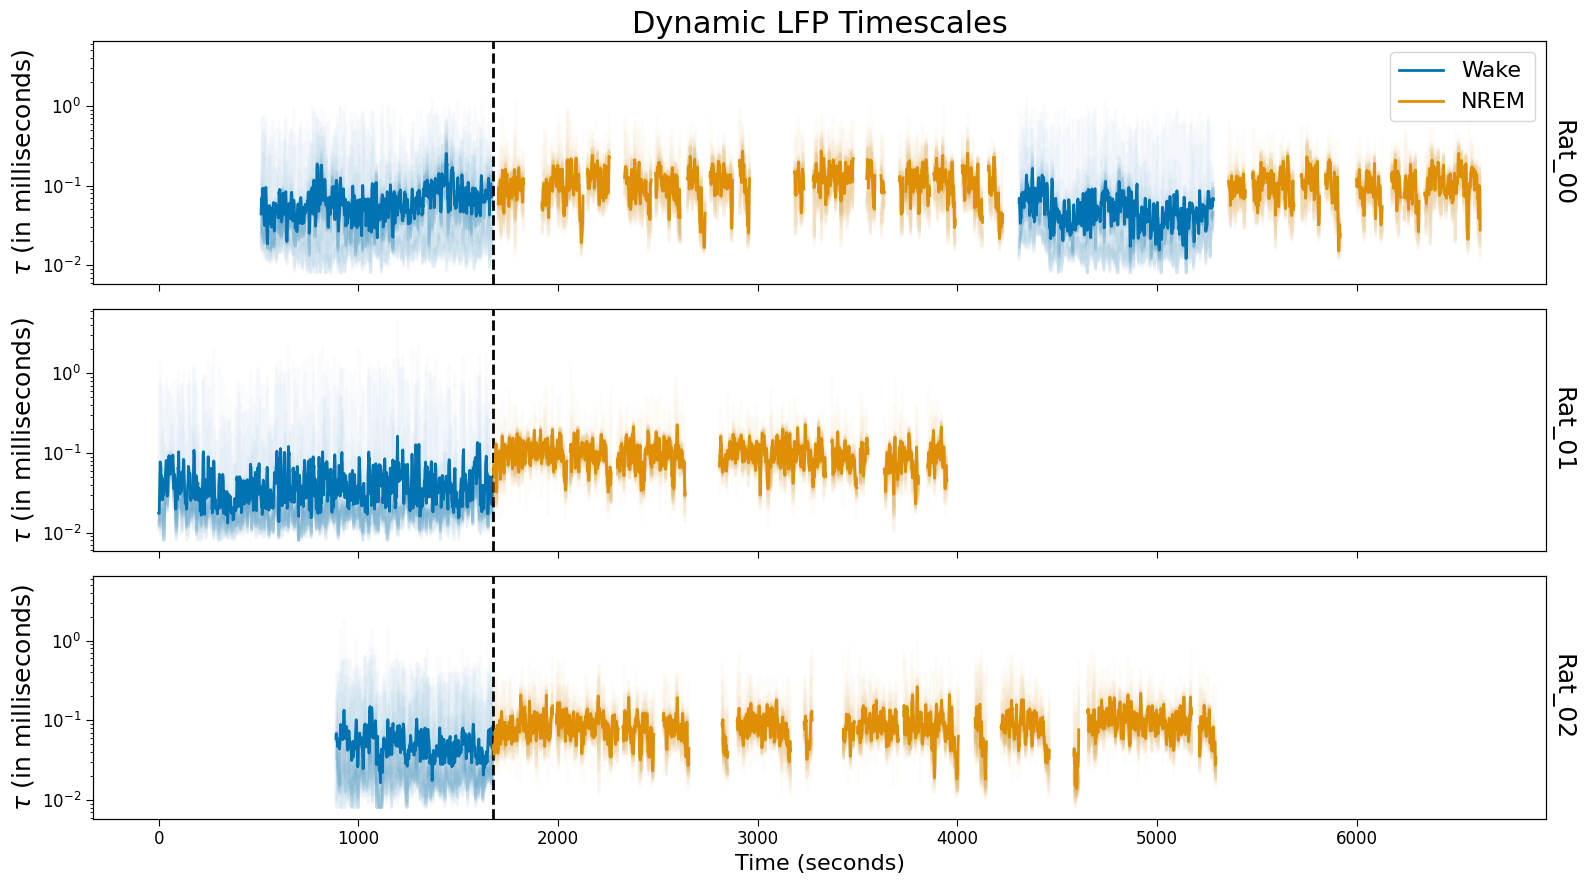

In [10]:
fs_lfp = 1250

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharex=True, sharey=True)

# Iterate over each animal
for i, base in enumerate(bases):
    
    # LFP: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_lfp, win_len, win_spacing)

    mids = start_end_wake.mean(axis=1).astype(int)
    
    shift_baseline = mids[0]
    
    mids -= shift_baseline
    
    split_inds = np.where(np.diff(mids) != 1250)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1
    
    
    shift = 2090000 - mids[_split_inds[0]]
    mids += shift

    # Plot wake
    times = np.arange(0, (mids[-1]+1)/fs_lfp, 1/fs_lfp)
    
    for j, l in enumerate(results_lfp_wake_dynamic[i][:, :, 0]):
        for mid, l in zip(np.split(mids, split_inds), np.split(l, split_inds)):
            axes[i].semilogy(times[mid], l, color='C0', alpha=.025)
        
    has_label = False
    l = results_lfp_wake_dynamic[i][:, :, 0].mean(axis=0)
    for mid, l in zip(np.split(mids, split_inds), np.split(l, split_inds)):
        if has_label:
            axes[i].semilogy(times[mid], l, color='C0', alpha=1)
        else:
            axes[i].semilogy(times[mid], l, color='C0', alpha=1, label="Wake")
            has_label = True
    
    # Plot nrem
    mids = start_end_nrem.mean(axis=1).astype(int)
    mids -= shift_baseline
    mids += shift
    
    axes[i].axvline(times[2090000], color='k', ls='--')
    split_inds = np.where(np.diff(mids) != 1250)[0]+1
    times = np.arange(0, (mids[-1]+1)/fs_lfp, 1/fs_lfp)
        
    for j, l in enumerate(results_lfp_nrem_dynamic[i][:, :, 0]):
        for mid, l in zip(np.split(mids, split_inds), np.split(l, split_inds)):
            axes[i].semilogy(times[mid], l, color='C1', alpha=.025)
            
    has_label = False
    l = results_lfp_nrem_dynamic[i][:, :, 0].mean(axis=0)
    for mid, l in zip(np.split(mids, split_inds), np.split(l, split_inds)):
        if has_label:
            axes[i].semilogy(times[mid], l, color='C1', alpha=1)
        else:
            axes[i].semilogy(times[mid], l, color='C1', alpha=1, label='NREM')
            has_label = True
        
_labels = [f'Rat_0{i}' for i in range(3)]
for i in range(3):
    ax = axes[i].twinx()
    ax.set_yticks([])
    ax.set_ylabel(_labels[i], rotation=-90, size=18,labelpad=15)
    
axes[0].set_title('Dynamic LFP Timescales', size=22)
axes[0].legend(facecolor='white', fontsize=16)
axes[-1].set_xlabel('Time (seconds)', size=16)

for ax in axes:
    ax.set_ylabel(r'$\tau$ (in milliseconds)')
    
plt.tight_layout()

plt.savefig('dynamic_timescales_v1.pdf', facecolor='white', dpi=300)

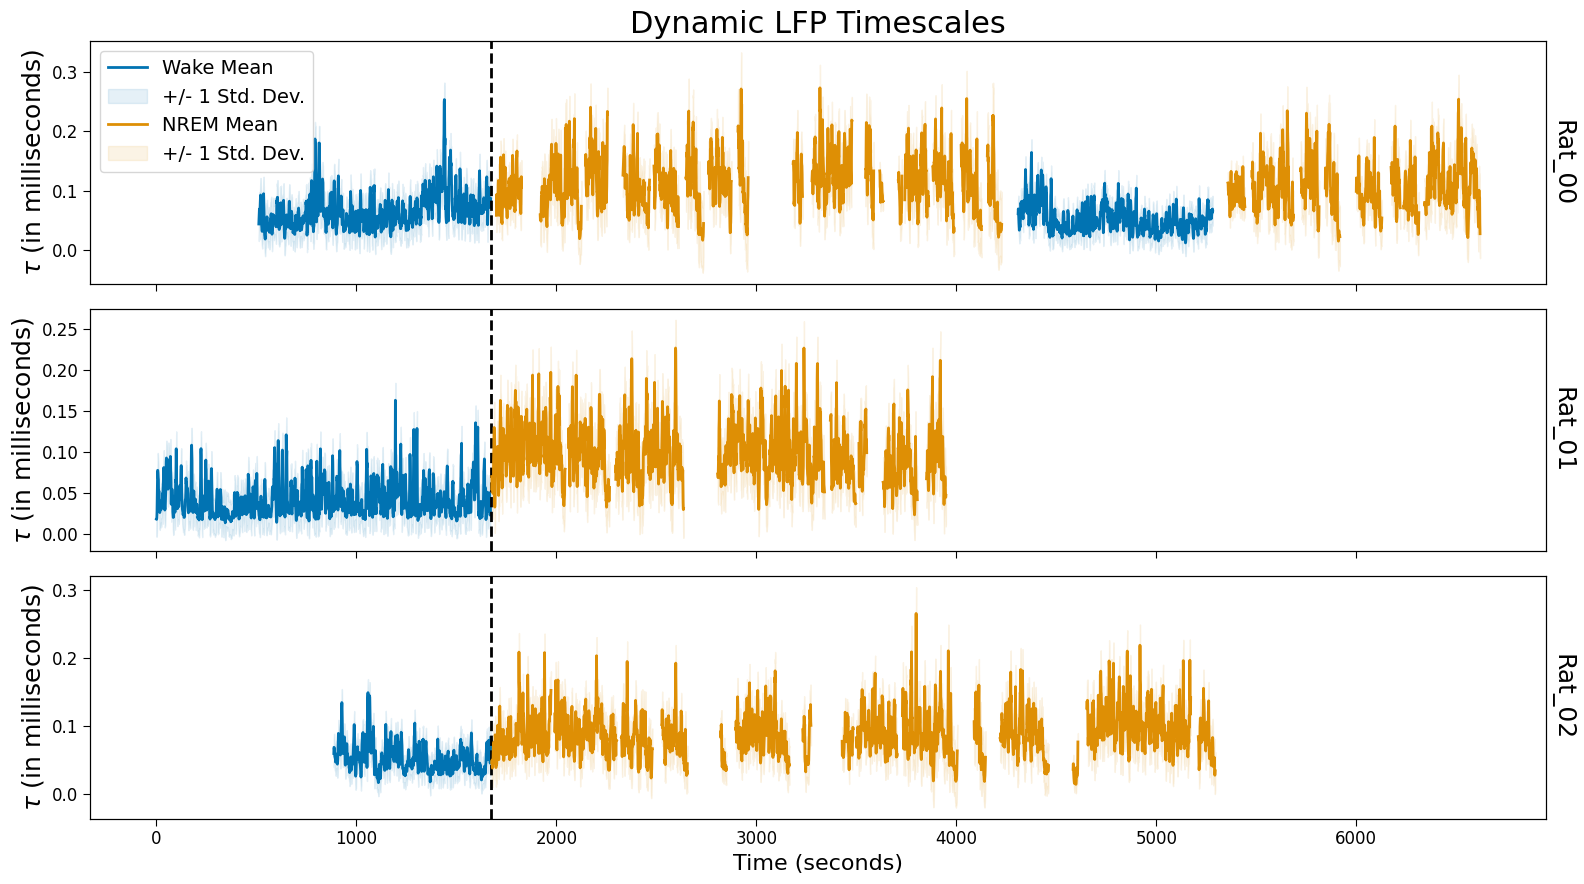

In [12]:
fs_lfp = 1250

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharex=True)

# Iterate over each animal
for i, base in enumerate(bases):
    
    # LFP: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_lfp, win_len, win_spacing)

    mids = start_end_wake.mean(axis=1).astype(int)
    
    shift_baseline = mids[0]
    
    mids -= shift_baseline
    
    split_inds = np.where(np.diff(mids) != 1250)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1
    
    
    shift = 2090000 - mids[_split_inds[0]]
    mids += shift

    # Plot wake
    has_label = False
    l = results_lfp_wake_dynamic[i][:, :, 0].mean(axis=0)
    for mid, l in zip(np.split(mids, split_inds), np.split(l, split_inds)):
        
        std = 1*l.std()
            
        if has_label:
            axes[i].plot(times[mid], l, color='C0', alpha=1)
            axes[i].fill_between(times[mid], l.astype(float)-std, l.astype(float)+std,
                             color='C0', alpha=.1)
        else:
            axes[i].plot(times[mid], l, color='C0', alpha=1, label='Wake Mean')
            axes[i].fill_between(times[mid], l.astype(float)-std, l.astype(float)+std,
                             color='C0', alpha=.1, label='+/- 1 Std. Dev.')
            
        has_label = True
    
    # Plot nrem
    mids = start_end_nrem.mean(axis=1).astype(int)
    mids -= shift_baseline
    mids += shift
    
    axes[i].axvline(times[2090000], color='k', ls='--')
    split_inds = np.where(np.diff(mids) != 1250)[0]+1
    times = np.arange(0, (mids[-1]+1)/fs_lfp, 1/fs_lfp)
        
    has_label = False
    l = results_lfp_nrem_dynamic[i][:, :, 0].mean(axis=0)
    for mid, l in zip(np.split(mids, split_inds), np.split(l, split_inds)):
        
        std = 1*l.std()
         
        if has_label:
            axes[i].plot(times[mid], l, color='C1', alpha=1)
            axes[i].fill_between(times[mid], l.astype(float)-std, l.astype(float)+std,
                                 color='C1', alpha=.1)
        else:
            axes[i].plot(times[mid], l, color='C1', alpha=1, label='NREM Mean')
            axes[i].fill_between(times[mid], l.astype(float)-std, l.astype(float)+std,
                                 color='C1', alpha=.1, label='+/- 1 Std. Dev.')
        
        has_label = True
            
        
        
_labels = [f'Rat_0{i}' for i in range(3)]
for i in range(3):
    ax = axes[i].twinx()
    ax.set_yticks([])
    ax.set_ylabel(_labels[i], rotation=-90, size=18,labelpad=15)
    
axes[0].set_title('Dynamic LFP Timescales', size=22)
axes[0].legend(facecolor='white', fontsize=14)
axes[-1].set_xlabel('Time (seconds)', size=16)

for ax in axes:
    ax.set_ylabel(r'$\tau$ (in milliseconds)')
    
plt.tight_layout()
#ax.set_xlim(0, 4250)
#axes[0].set_ylim(-0.05, None)
#axes[0].set_yticks(ticks=[0, .1, .2, .3, .4])
plt.savefig('dynamic_timescales_v2.pdf', facecolor='white', dpi=300)

In [13]:
def plot_trace(times, taus, mids, split_inds, ax, color, trial,
               take_mean=True, stds=1, plot_method='plot', fill=True):
    
    # Plot wake
    has_label = False
    
    if take_mean:
        l = taus[:, :, 0].mean(axis=0)
    else:
        l = taus[:, 0]
        

    for mid, l in zip(np.split(mids, split_inds), np.split(l, split_inds)):
        
        std = stds * l.std()
        
        if has_label:
            getattr(ax, plot_method)(times[mid], l, color=color, alpha=1)
            if fill:
                ax.fill_between(times[mid], l.astype(float)-std, l.astype(float)+std,
                                color=color, alpha=.1)
        else:
            getattr(ax, plot_method)(times[mid], l, color=color, alpha=1, label=f'{trial} Mean')
            if fill:
                ax.fill_between(times[mid], l.astype(float)-std, l.astype(float)+std,
                                color=color, alpha=.1, label=f'+/- {2} Std. Dev.')
            
        has_label = True

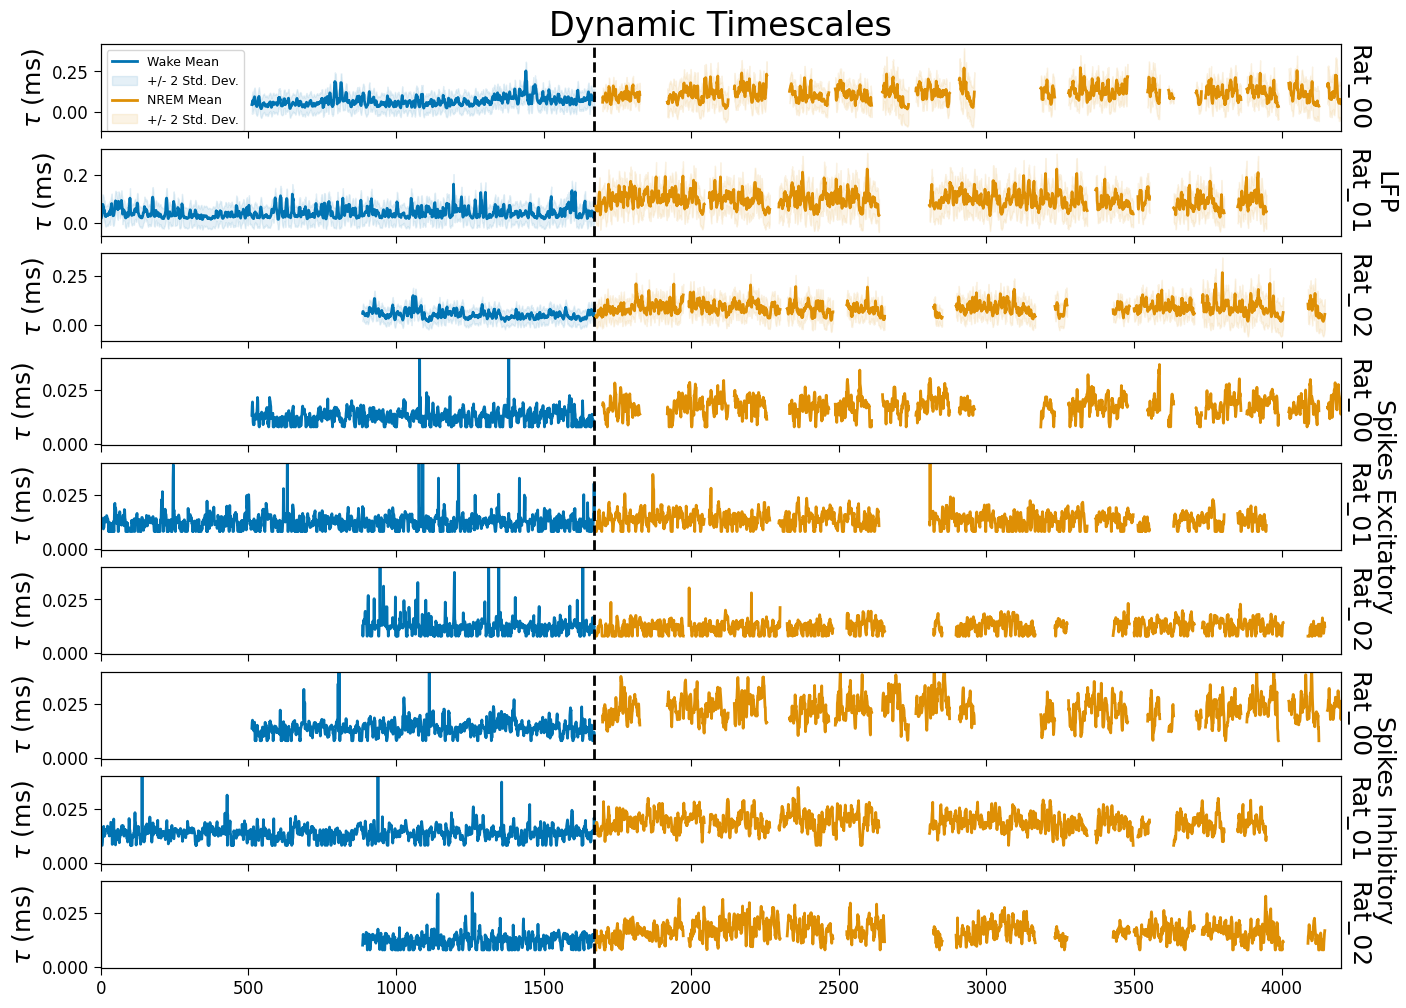

In [14]:
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(16, 12), sharex=True)

fs_lfp = 1250
stds = 2

plot_method = 'plot'
#plot_method = 'semilogy'

# Iterate over each animal
for i, base in enumerate(bases):
    
    # LFP: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_lfp, win_len, win_spacing)

    # Align plots
    mids = start_end_wake.mean(axis=1).astype(int)
    shift_baseline = mids[0]
    mids -= shift_baseline
    
    split_inds = np.where(np.diff(mids) != 1250)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1
    
    shift = 2090000 - mids[_split_inds[0]]
    mids += shift
        
    times = np.arange(0, (mids[-1]+1)/fs_lfp, 1/fs_lfp)
    
    # Plot wake
    plot_trace(times, results_lfp_wake_dynamic[i], mids, split_inds,
               axes[i], 'C0', 'Wake', stds=stds)
    
    # Plot nrem
    mids = start_end_nrem.mean(axis=1).astype(int)
    mids -= shift_baseline
    mids += shift
    
    axes[i].axvline(times[2090000], color='k', ls='--')
    split_inds = np.where(np.diff(mids) != 1250)[0]+1
    times = np.arange(0, (mids[-1]+1)/fs_lfp, 1/fs_lfp)
        
    plot_trace(times, results_lfp_nrem_dynamic[i], mids, split_inds,
               axes[i], 'C1', 'NREM', stds=stds, plot_method=plot_method)  
    
        
for i, base in enumerate(bases):
    
    # Spikes: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_spikes, win_len, win_spacing)
    
    # Align plots
    mids = start_end_wake.mean(axis=1).astype(int)
    shift_baseline = mids[0]
    mids -= shift_baseline

    split_inds = np.where(np.diff(mids) != fs_spikes)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1

    shift = int(((2090000/fs_lfp)*fs_spikes) - mids[_split_inds[0]])
    mids += shift
    
    # Plot wake
    times = np.arange(0, (mids[-1]+1)/fs_spikes, 1/fs_spikes)
                       
    plot_trace(times, results_spikes_e_wake_dynamic[i], mids, split_inds,
               axes[i+3], 'C0', 'Wake', fill=False, take_mean=False, plot_method=plot_method)
    
    
    # Plot NREM
    mids = start_end_nrem.mean(axis=1).astype(int)
    mids -= shift_baseline

    split_inds = np.where(np.diff(mids) != fs_spikes)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1
    mids += shift
    
    # Plot wake
    times = np.arange(0, (mids[-1]+1)/fs_spikes, 1/fs_spikes)
                       
    plot_trace(times, results_spikes_e_nrem_dynamic[i], mids, split_inds,
               axes[i+3], 'C1', 'NREM', fill=False, take_mean=False, plot_method=plot_method)


    axes[i+3].axvline(times[int(((2090000/fs_lfp)*fs_spikes))], color='k', ls='--')
    
    
for i, base in enumerate(bases):
    
    # Spikes: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_spikes, win_len, win_spacing)
    
    # Align plots
    mids = start_end_wake.mean(axis=1).astype(int)
    shift_baseline = mids[0]
    mids -= shift_baseline

    split_inds = np.where(np.diff(mids) != fs_spikes)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1

    shift = int(((2090000/fs_lfp)*fs_spikes) - mids[_split_inds[0]])
    mids += shift
    
    # Plot wake
    times = np.arange(0, (mids[-1]+1)/fs_spikes, 1/fs_spikes)
                       
    plot_trace(times, results_spikes_i_wake_dynamic[i], mids, split_inds,
               axes[i+6], 'C0', 'Wake', fill=False, take_mean=False, plot_method=plot_method)
    
    
    # Plot NREM
    mids = start_end_nrem.mean(axis=1).astype(int)
    mids -= shift_baseline

    split_inds = np.where(np.diff(mids) != fs_spikes)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1
    mids += shift
    
    # Plot wake
    times = np.arange(0, (mids[-1]+1)/fs_spikes, 1/fs_spikes)
                       
    plot_trace(times, results_spikes_i_nrem_dynamic[i], mids, split_inds,
               axes[i+6], 'C1', 'NREM', fill=False, take_mean=False, plot_method=plot_method)


    axes[i+6].axvline(times[int(((2090000/fs_lfp)*fs_spikes))], color='k', ls='--')
    
    
_labels = [f'Rat_0{i}' for i in range(3)]
for i in range(9):
    ax = axes[i].twinx()
    ax.set_yticks([])
    if i == 1:
        ax.set_ylabel(f'LFP\n{_labels[i%3]}', rotation=-90, size=18,labelpad=35)
    elif i == 4:
        ax.set_ylabel(f'Spikes Excitatory\n{_labels[i%3]}', rotation=-90, size=18,labelpad=35)
    elif i == 7:
        ax.set_ylabel(f'Spikes Inhibitory\n{_labels[i%3]}', rotation=-90, size=18,labelpad=35)
    else:
        ax.set_ylabel(_labels[i%3], rotation=-90, size=18,labelpad=15)
    
#axes[0].set_title('Dynamic LFP Timescales', size=22)
#axes[-1].set_xlabel('Time (seconds)', size=16)
#axes[0].set_ylim(-0.05, None)

axes[0].legend(facecolor='white', fontsize=9)
for ind, ax in enumerate(axes):
    ax.set_ylabel(r'$\tau$ (ms)')
    
#plt.tight_layout()
ax.set_xlim(0, 4200)

axes[3].set_ylim(-.0005, .04)
axes[4].set_ylim(-.0005, .04)
axes[5].set_ylim(-.0005, .04)
axes[6].set_ylim(-.0005, .04)
axes[7].set_ylim(-.0005, .04)
axes[8].set_ylim(-.0005, .04)

axes[0].set_title('Dynamic Timescales')
plt.savefig('dynamic_timescales_v3.pdf', facecolor='white', dpi=300)

In [15]:
def plot_trace(times, taus, mids, split_inds, ax, color, trial,
               take_mean=True, stds=1, plot_method='plot', fill=True):
    
    # Plot wake
    has_label = False
    
    if take_mean:
        l = taus[:, :, 0].mean(axis=0)
    else:
        l = taus[:, 0]
        

    for mid, l in zip(np.split(mids, split_inds), np.split(l, split_inds)):
        
        std = stds * l.std()
        
        if has_label:
            getattr(ax, plot_method)(times[mid], l, color=color, alpha=1)
        else:
            getattr(ax, plot_method)(times[mid], l, color=color, alpha=1, label=f'{trial}')
            
        has_label = True

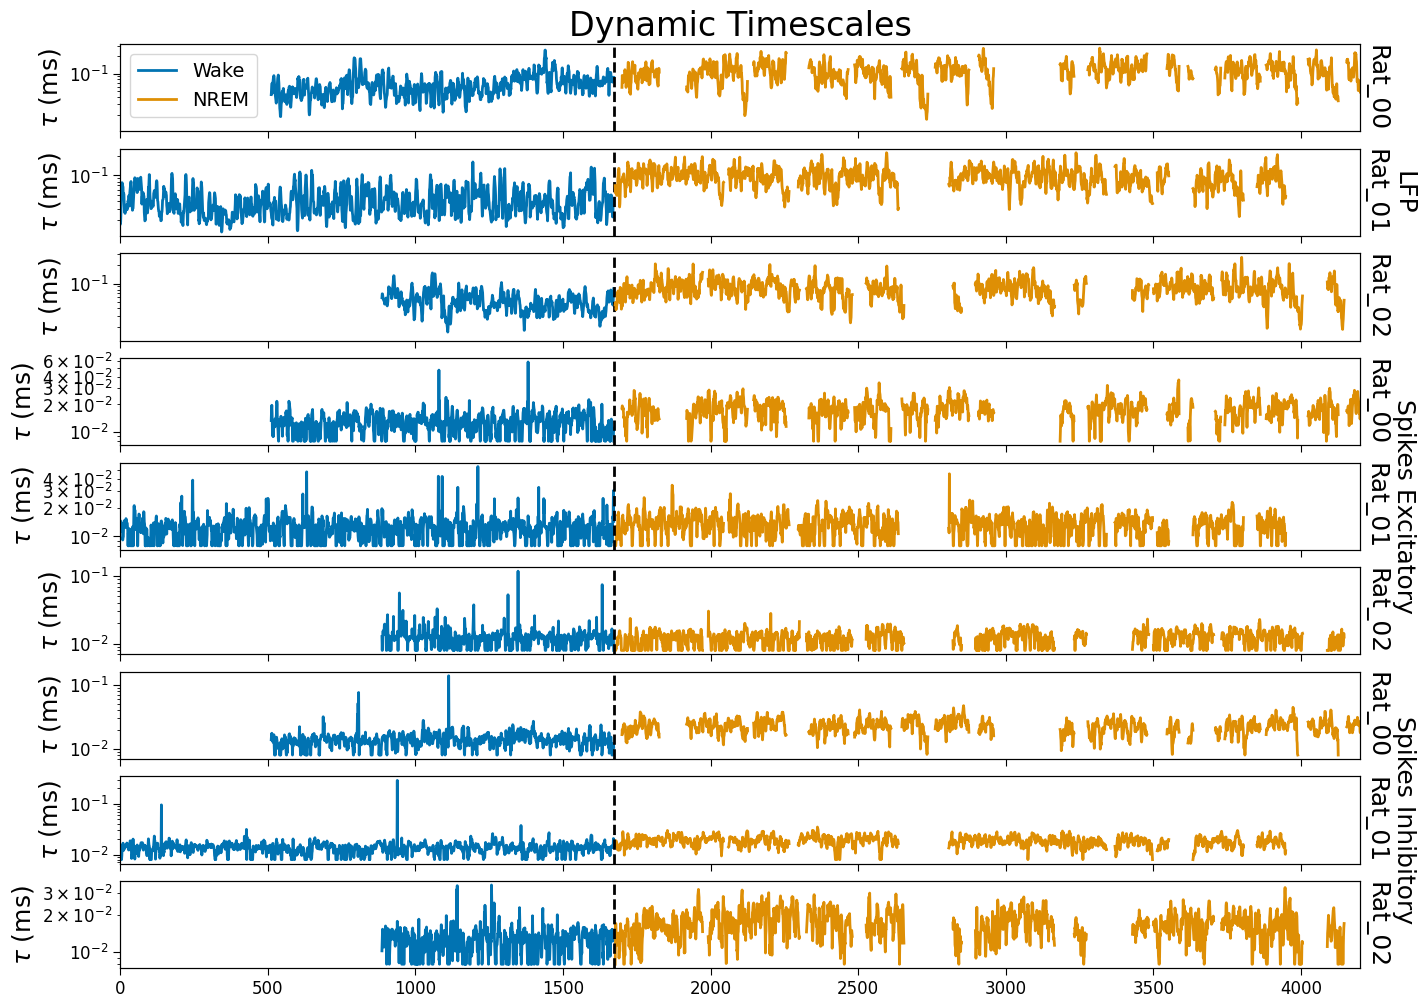

In [16]:
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(16, 12), sharex=True)

fs_lfp = 1250
stds = 2

#plot_method = 'plot'
plot_method = 'semilogy'

# Iterate over each animal
for i, base in enumerate(bases):
    
    # LFP: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_lfp, win_len, win_spacing)

    # Align plots
    mids = start_end_wake.mean(axis=1).astype(int)
    shift_baseline = mids[0]
    mids -= shift_baseline
    
    split_inds = np.where(np.diff(mids) != 1250)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1
    
    shift = 2090000 - mids[_split_inds[0]]
    mids += shift
        
    times = np.arange(0, (mids[-1]+1)/fs_lfp, 1/fs_lfp)
    
    # Plot wake
    plot_trace(times, results_lfp_wake_dynamic[i], mids, split_inds,
               axes[i], 'C0', 'Wake', fill=False)
    
    # Plot nrem
    mids = start_end_nrem.mean(axis=1).astype(int)
    mids -= shift_baseline
    mids += shift
    
    axes[i].axvline(times[2090000], color='k', ls='--')
    split_inds = np.where(np.diff(mids) != 1250)[0]+1
    times = np.arange(0, (mids[-1]+1)/fs_lfp, 1/fs_lfp)
        
    plot_trace(times, results_lfp_nrem_dynamic[i], mids, split_inds,
               axes[i], 'C1', 'NREM', fill=False, plot_method=plot_method)  
    
        
for i, base in enumerate(bases):
    
    # Spikes: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_spikes, win_len, win_spacing)
    
    # Align plots
    mids = start_end_wake.mean(axis=1).astype(int)
    shift_baseline = mids[0]
    mids -= shift_baseline

    split_inds = np.where(np.diff(mids) != fs_spikes)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1

    shift = int(((2090000/fs_lfp)*fs_spikes) - mids[_split_inds[0]])
    mids += shift
    
    # Plot wake
    times = np.arange(0, (mids[-1]+1)/fs_spikes, 1/fs_spikes)
                       
    plot_trace(times, results_spikes_e_wake_dynamic[i], mids, split_inds,
               axes[i+3], 'C0', 'Wake', stds=stds, take_mean=False, plot_method=plot_method)
    
    
    # Plot NREM
    mids = start_end_nrem.mean(axis=1).astype(int)
    mids -= shift_baseline

    split_inds = np.where(np.diff(mids) != fs_spikes)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1
    mids += shift
    
    # Plot wake
    times = np.arange(0, (mids[-1]+1)/fs_spikes, 1/fs_spikes)
                       
    plot_trace(times, results_spikes_e_nrem_dynamic[i], mids, split_inds,
               axes[i+3], 'C1', 'NREM', stds=stds, take_mean=False, plot_method=plot_method)


    axes[i+3].axvline(times[int(((2090000/fs_lfp)*fs_spikes))], color='k', ls='--')
    
    
for i, base in enumerate(bases):
    
    # Spikes: annotations
    start_end_wake, start_end_nrem = read_annotations(base, fs_spikes, win_len, win_spacing)
    
    # Align plots
    mids = start_end_wake.mean(axis=1).astype(int)
    shift_baseline = mids[0]
    mids -= shift_baseline

    split_inds = np.where(np.diff(mids) != fs_spikes)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1

    shift = int(((2090000/fs_lfp)*fs_spikes) - mids[_split_inds[0]])
    mids += shift
    
    # Plot wake
    times = np.arange(0, (mids[-1]+1)/fs_spikes, 1/fs_spikes)
                       
    plot_trace(times, results_spikes_i_wake_dynamic[i], mids, split_inds,
               axes[i+6], 'C0', 'Wake', fill=False, take_mean=False, plot_method=plot_method)
    
    
    # Plot NREM
    mids = start_end_nrem.mean(axis=1).astype(int)
    mids -= shift_baseline

    split_inds = np.where(np.diff(mids) != fs_spikes)[0]+1
    _split_inds = [len(mids)-1] if len(split_inds) == 0 else split_inds-1
    mids += shift
    
    # Plot wake
    times = np.arange(0, (mids[-1]+1)/fs_spikes, 1/fs_spikes)
                       
    plot_trace(times, results_spikes_i_nrem_dynamic[i], mids, split_inds,
               axes[i+6], 'C1', 'NREM', fill=False, take_mean=False, plot_method=plot_method)


    axes[i+6].axvline(times[int(((2090000/fs_lfp)*fs_spikes))], color='k', ls='--')
    
    
_labels = [f'Rat_0{i}' for i in range(3)]
for i in range(9):
    ax = axes[i].twinx()
    ax.set_yticks([])
    if i == 1:
        ax.set_ylabel(f'LFP\n{_labels[i%3]}', rotation=-90, size=18,labelpad=35)
    elif i == 4:
        ax.set_ylabel(f'Spikes Excitatory\n{_labels[i%3]}', rotation=-90, size=18,labelpad=35)
    elif i == 7:
        ax.set_ylabel(f'Spikes Inhibitory\n{_labels[i%3]}', rotation=-90, size=18,labelpad=35)
    else:
        ax.set_ylabel(_labels[i%3], rotation=-90, size=18,labelpad=15)
    
#axes[-1].set_xlabel('Time (seconds)', size=16)
#axes[0].set_ylim(-0.05, None)

axes[0].legend(facecolor='white', fontsize=14)
for ind, ax in enumerate(axes):
    ax.set_ylabel(r'$\tau$ (ms)')
    
#plt.tight_layout()
ax.set_xlim(0, 4200)


axes[0].set_title('Dynamic Timescales')

for ax in axes:
    ax.ticklabel_format(axis='x', style='sci', scilimits=(1, 20))
    
plt.savefig('dynamic_timescales_v4.pdf', facecolor='white', dpi=300)